# `DMKDE` performance on a `normal_mult`

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

## About the libraries we need

Install `qmc`

Let´s install (git clone to the file system of the Colab VM) the module `qmc` which contains
> Custom models inherited from the super class `tf.keras.Model`.

> Custom layers inherited from the super class `tf.keras.layers.Layer`.

More information on customization when using `tf` this can be found at [here](https://www.tensorflow.org/tutorials/customization/custom_layers#models_composing_layers).

In [2]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 516 (delta 46), reused 37 (delta 37), pack-reused 439
Receiving objects: 100% (516/516), 37.05 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (235/235), done.


Install `KDEpy`

In [3]:
pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 4.2 MB/s 


Install `fastKDE`

In [4]:
pip install fastkde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 952 kB 4.2 MB/s 


General ones that include:

- `pandas` : For managing dataframes that come from txt files.
- `numpy` : For managing multidimensional arrays.
- `pylab` : For plotting purposes.

In [5]:
import pandas as pd
import numpy as np
import pylab as pl
from typeguard import typechecked
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
import tensorflow_probability as tfp
import qmc.tf.layers as layers
import qmc.tf.models as models
from scipy.stats import norm, bernoulli, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from KDEpy import NaiveKDE
from KDEpy import TreeKDE
from KDEpy import FFTKDE
from fastkde import fastKDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns

 Clone repo for sampling made with Pytorch

In [6]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R nf
    !git clone https://github.com/VishakhG/normalizing-flows nf
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'nf': No such file or directory
Cloning into 'nf'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 12), reused 48 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [7]:
import nf.src.densities as densitiesnf
import nf.src.normalizing_flows as nfs
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

In [8]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

## Auxiliary functions

Plot density function

In [ ]:
def plot_dens_func(dens_func, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    x = np.linspace(-6, 6, int(1e2))
    y = np.linspace(-6, 6, int(1e2))
    xx, yy = np.meshgrid(x, y)
    in_tens = tf.constant(np.vstack([xx.ravel(), yy.ravel()]).T,dtype=tf.float32)
    z = dens_func(in_tens).numpy().reshape(xx.shape)

    cmap = plt.get_cmap('inferno')
    ax.contourf(x, y, z.reshape(xx.shape), cmap=cmap)

Constant for `DMKDE` and `EIG_DMKDE` predictions

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

Define `raw_kde` method 

In [ ]:
def raw_kde(x_test, x_train, gamma = 1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  coefficient = 1 /  (2*np.pi*sigma**2)**(x_train.shape[1]/2) 
  constant_outside = 1/(x_train.shape[0]) * coefficient
  result = constant_outside * np.sum(exponential)  
  return result

## Data

Mixture of 10 gaussian components generated using `tensorflow_probability`
***

Sample size 

In [ ]:
sample_size = 1000000

Set $4$ locations and scales

NO

In [ ]:
np.random.seed(10)

location = []
scale = []

for i in range(4):
  location.append(np.random.uniform(low=-1, high=1, size = 10).astype(np.float32).tolist())
  scale.append(np.random.uniform(low=0.01, high=10, size = 10).astype(np.float32).tolist())

NO

In [ ]:
np.random.seed(10)

location = []
scale = []

for i in range(4):
  location.append(np.random.randint(low=-10, high=10, size = 10).astype(np.float32).tolist())
  scale.append(np.random.randint(low=0, high=1000, size = 10).astype(np.float32).tolist())


YES

In [ ]:
np.random.seed(10)

location = []
scale = []

for i in range(4):
  location.append(np.random.uniform(low=-0.5, high=0.5, size = 10).astype(np.float32).tolist())
  scale.append(np.random.uniform(low=0.01, high=0.5, size = 10).astype(np.float32).tolist())

Create the mixture model

In [ ]:
# Create a mixture of two Gaussians:
tfd = tfp.distributions
mix = 0.5


components = []
for i in range(4):
  components.append(tfd.MultivariateNormalDiag(
      loc=location[i],
      scale_diag=scale[i]))

multi_gauss = tfd.Mixture(
  cat=tfd.Categorical(probs=[0.25, 0.25, 0.25,0.25]),
  components=components
)

Generate the sample - Do not run

In [ ]:
X = multi_gauss.sample(sample_size)

In [ ]:
X = X.numpy()

Save data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#np.savetxt(fname="/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NORMAL_MULT/mixt_1M.csv", delimiter=" ", X = X)

Load data

In [ ]:
X = np.loadtxt("/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NORMAL_MULT/mixt_1M.csv")
#X = np.loadtxt("/content/drive/MyDrive/Datasets/NORMAL_MULT/mixt_1M.csv")

Scale the data

In [ ]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [ ]:
X.shape

(1000000, 10)

True densities

In [ ]:
X_densities = multi_gauss.log_prob(X).numpy()

In [ ]:
X_densities.shape

(1000000,)

In [ ]:
X_densities.max()

6.909791

In [ ]:
X_densities.min()

-19.0509

Histogram of distances with 1000 samples - Do not run



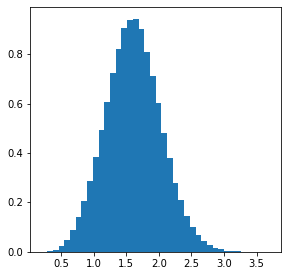

In [ ]:
distances_X = euclidean_distances(X[:1000],X[:1000])
plt.hist(distances_X[np.triu_indices_from(distances_X, k=1)].ravel(), density = True, bins=40);

We suggest a `bw = 1.6`.

## Experiment 1 : 10

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 10D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 10D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 10D data set shape is:(10, 10) and their densities shape is (10,)
Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)


### Fixing bandwidth

Cross Validation with 5 folds 

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new]))  
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Best gamma:2 with L1_error 6.192012260117309


Fixed gamma

In [ ]:
gamma = 2

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.5

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test]))

CPU times: user 165 ms, sys: 1.87 ms, total: 167 ms
Wall time: 167 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

6.783428709468687

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = np.log(NaiveKDE_density.evaluate(X_test))

CPU times: user 12.5 ms, sys: 22 µs, total: 12.5 ms
Wall time: 14.5 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

6.783428709467899

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = np.log(TreeKDE_density.evaluate(X_test))

CPU times: user 3.05 s, sys: 38.1 ms, total: 3.09 s
Wall time: 3.06 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

6.94768009815274

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = KernelDensitybt_density.score_samples(X_test)

CPU times: user 12.5 ms, sys: 22 µs, total: 12.6 ms
Wall time: 13.8 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

6.783428709468685

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = KernelDensitykdt_density.score_samples(X_test)

CPU times: user 15.8 ms, sys: 87 µs, total: 15.9 ms
Wall time: 18 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

6.783428709468685

#### `DMKDE`

Cross Validation for our method

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 500
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

1/1 [==============================] - 0s 78ms/step
Best gamma:4 with L1_error 2.920403611660004


##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

1/1 [==============================] - 0s 77ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 618 ms, sys: 350 ms, total: 968 ms
Wall time: 848 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

3.6615281250000002

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

1/1 [==============================] - 0s 101ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10) )

CPU times: user 1.56 s, sys: 249 ms, total: 1.8 s
Wall time: 1.42 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.1280865234375

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

1/1 [==============================] - 0s 288ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 1min 28s, sys: 5.21 s, total: 1min 33s
Wall time: 52.5 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.1149251953125

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

1/1 [==============================] - 0s 74ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 9min 36s, sys: 5.4 s, total: 9min 42s
Wall time: 5min 1s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.094077734375

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

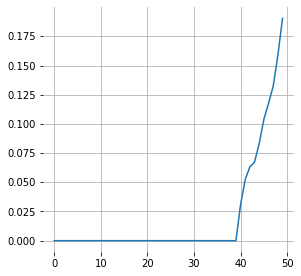

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_50.predict(X_test))

CPU times: user 425 ms, sys: 37.3 ms, total: 463 ms
Wall time: 409 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

3.6615281250000002

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

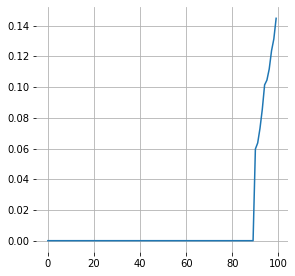

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_100.predict(X_test))

CPU times: user 457 ms, sys: 30.3 ms, total: 488 ms
Wall time: 390 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.1280865234375

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

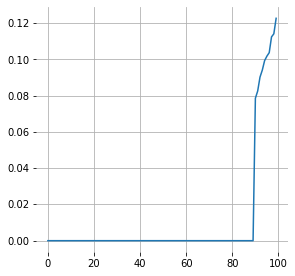

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_500.predict(X_test))

CPU times: user 489 ms, sys: 40.4 ms, total: 529 ms
Wall time: 735 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.1149251953125

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

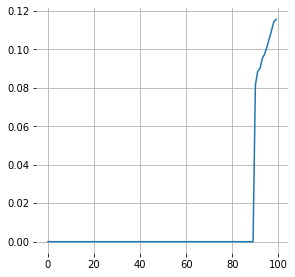

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_1000.predict(X_test))

CPU times: user 642 ms, sys: 47.4 ms, total: 690 ms
Wall time: 513 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.094077734375

## Experiment 2 : 100

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 10D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 10D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 10D data set shape is:(100, 10) and their densities shape is (100,)
Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)


### Fixing bandwidth

Cross Validation with 5 folds 

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new]))  
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Best gamma:8 with L1_error 4.1310028938078265


Fixed gamma

In [ ]:
gamma = 8

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.25

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test]))

CPU times: user 343 ms, sys: 1.45 ms, total: 344 ms
Wall time: 347 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

4.120027318076481

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = np.log(NaiveKDE_density.evaluate(X_test))

CPU times: user 139 ms, sys: 6.03 ms, total: 145 ms
Wall time: 146 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

4.120027317204877

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = np.log(TreeKDE_density.evaluate(X_test))

CPU times: user 4.96 s, sys: 94.9 ms, total: 5.06 s
Wall time: 4.97 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

6.941808703480529

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = KernelDensitybt_density.score_samples(X_test)

CPU times: user 86.3 ms, sys: 0 ns, total: 86.3 ms
Wall time: 87.1 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

4.120027317733886

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = KernelDensitykdt_density.score_samples(X_test)

CPU times: user 107 ms, sys: 779 µs, total: 108 ms
Wall time: 111 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

4.120027318043861

#### `DMKDE`

Cross Validation for our method

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 500
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd_500.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

3/3 [==============================] - 0s 5ms/step
Best gamma:4 with L1_error 2.1865321731567384


##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 644 ms, sys: 46.4 ms, total: 690 ms
Wall time: 695 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

3.731667578125

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10) )

CPU times: user 1.56 s, sys: 83.8 ms, total: 1.65 s
Wall time: 1.26 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.0807652343750003

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 1min 30s, sys: 1.84 s, total: 1min 32s
Wall time: 49.8 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.0039873046875

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 9min 42s, sys: 3.13 s, total: 9min 45s
Wall time: 5min 1s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

1.9813998046875

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

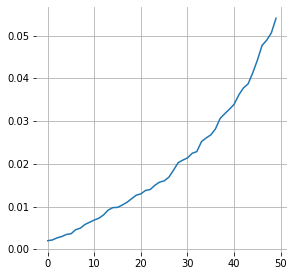

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_50.predict(X_test))

CPU times: user 442 ms, sys: 34.2 ms, total: 476 ms
Wall time: 413 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

3.73166796875

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

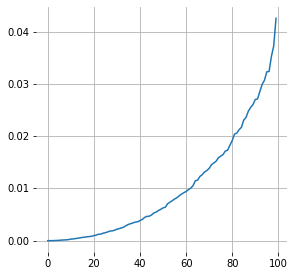

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_100.predict(X_test))

CPU times: user 511 ms, sys: 37.2 ms, total: 548 ms
Wall time: 746 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.076112890625

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

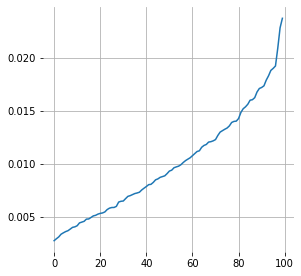

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_500.predict(X_test))

CPU times: user 531 ms, sys: 42.1 ms, total: 573 ms
Wall time: 741 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.9841558593750002

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

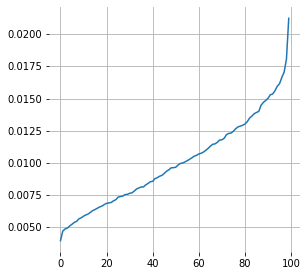

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_1000.predict(X_test))

CPU times: user 674 ms, sys: 63.7 ms, total: 738 ms
Wall time: 538 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.9652205078125

## Experiment 3 : 1000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 1000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 10D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 10D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 10D data set shape is:(1000, 10) and their densities shape is (1000,)
Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)


### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new]))  
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Best gamma:16 with L1_error 3.3683614970191007


Fixed gamma

In [ ]:
gamma = 16

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.17677669529663687

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test]))

CPU times: user 1.14 s, sys: 8.94 ms, total: 1.15 s
Wall time: 1.15 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

3.2417811303559643

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = np.log(NaiveKDE_density.evaluate(X_test))

CPU times: user 1.5 s, sys: 32.1 ms, total: 1.53 s
Wall time: 1.53 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

3.2417194920981665

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = np.log(TreeKDE_density.evaluate(X_test))

CPU times: user 5.17 s, sys: 57.5 ms, total: 5.23 s
Wall time: 5.19 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

6.515438213598312

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = KernelDensitybt_density.score_samples(X_test)

CPU times: user 895 ms, sys: 5.95 ms, total: 901 ms
Wall time: 898 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

3.2412764365763818

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = KernelDensitykdt_density.score_samples(X_test)

CPU times: user 1.04 s, sys: 5 ms, total: 1.05 s
Wall time: 1.05 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

3.2413354454756296

#### `DMKDE`

Cross Validation for our method

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 500
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd_50.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

25/25 [==============================] - 0s 2ms/step
Best gamma:4 with L1_error 2.145058349609375


##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

32/32 [==============================] - 0s 917us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 623 ms, sys: 50.4 ms, total: 673 ms
Wall time: 686 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

3.737024609375

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

32/32 [==============================] - 0s 943us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10) )

CPU times: user 1.55 s, sys: 300 ms, total: 1.85 s
Wall time: 1.44 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.0867705078125

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

32/32 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 1min 33s, sys: 2.7 s, total: 1min 36s
Wall time: 52.2 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.00568203125

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

32/32 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 9min 55s, sys: 3.86 s, total: 9min 59s
Wall time: 5min 9s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

1.9818744140625002

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

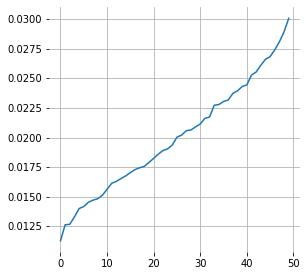

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_50.predict(X_test))

CPU times: user 439 ms, sys: 44.3 ms, total: 483 ms
Wall time: 370 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

3.737024609375

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

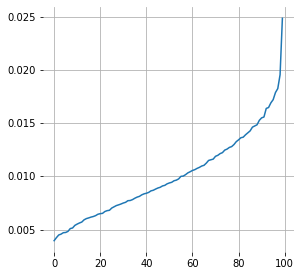

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_100.predict(X_test))

CPU times: user 447 ms, sys: 39.1 ms, total: 486 ms
Wall time: 409 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.0555982421875

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

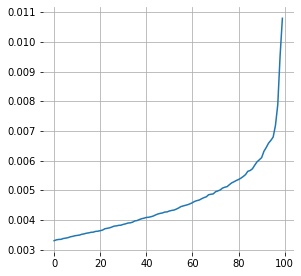

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_500.predict(X_test))

CPU times: user 508 ms, sys: 44.4 ms, total: 553 ms
Wall time: 736 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.8592244140625

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

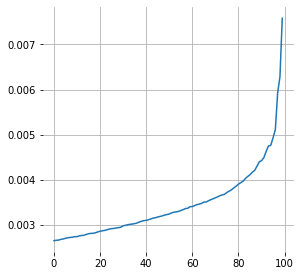

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_1000.predict(X_test))

CPU times: user 654 ms, sys: 49.5 ms, total: 704 ms
Wall time: 736 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.814158203125

## Experiment 4 : 10000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 10D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 10D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)
Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)


### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new]))  
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Fixed gamma

In [ ]:
gamma = 16

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.17677669529663687

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test]))

CPU times: user 6.74 s, sys: 245 ms, total: 6.99 s
Wall time: 6.98 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

2.648579616940393

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = np.log(NaiveKDE_density.evaluate(X_test))

CPU times: user 10.3 s, sys: 288 ms, total: 10.6 s
Wall time: 10.6 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

2.64857961258421

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = np.log(TreeKDE_density.evaluate(X_test))

CPU times: user 5.24 s, sys: 11.9 ms, total: 5.25 s
Wall time: 5.23 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

3.1429085717428906

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = KernelDensitybt_density.score_samples(X_test)

CPU times: user 8.13 s, sys: 21.7 ms, total: 8.16 s
Wall time: 8.12 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

2.64857689372986

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = KernelDensitykdt_density.score_samples(X_test)

CPU times: user 8.97 s, sys: 23.7 ms, total: 9 s
Wall time: 8.96 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

2.6485795859510604

#### `DMKDE`

Cross Validation for our method

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 500
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    print(mae)
  print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

250/250 [==============================] - 3s 794us/step
72.1616484375
250/250 [==============================] - 0s 839us/step
72.2028046875
250/250 [==============================] - 0s 796us/step
72.10059375
250/250 [==============================] - 0s 835us/step
72.167390625
250/250 [==============================] - 0s 797us/step
72.153859375
gamma:9.5367431640625e-07 error:72.15725937500001
250/250 [==============================] - 0s 852us/step
68.6959140625
250/250 [==============================] - 0s 823us/step
68.7370703125
250/250 [==============================] - 0s 848us/step
68.634859375
250/250 [==============================] - 0s 859us/step
68.70165625
250/250 [==============================] - 0s 854us/step
68.688125
gamma:1.9073486328125e-06 error:68.691525
250/250 [==============================] - 0s 835us/step
65.2301875
250/250 [==============================] - 0s 897us/step
65.2713515625
250/250 [==============================] - 0s 851us/step
65.1691367187

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 500
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

##### dim = 50

In [ ]:
gamma = 8

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

313/313 [==============================] - 0s 893us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 639 ms, sys: 52.5 ms, total: 691 ms
Wall time: 690 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

3.73664765625

##### dim = 100

Train

In [ ]:
gamma=5

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

313/313 [==============================] - 0s 876us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10) )

CPU times: user 1.62 s, sys: 102 ms, total: 1.72 s
Wall time: 1.32 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.08758984375

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

313/313 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time dmkde_densities = np.log(qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 1min 33s, sys: 2.25 s, total: 1min 35s
Wall time: 51.7 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.0027849609375

##### dim = 1000

In [ ]:
gamma = 7

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

313/313 [==============================] - 1s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 9min 37s, sys: 2.79 s, total: 9min 40s
Wall time: 4min 59s


In [ ]:
dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

1.9788185546875001

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

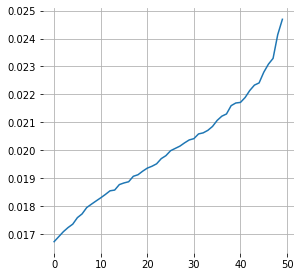

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_50.predict(X_test))

CPU times: user 580 ms, sys: 36.3 ms, total: 616 ms
Wall time: 503 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

3.73664765625

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

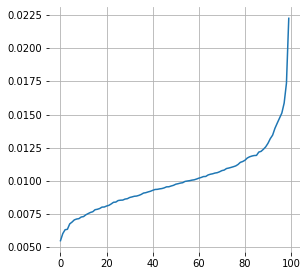

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_100.predict(X_test))

CPU times: user 481 ms, sys: 41.2 ms, total: 523 ms
Wall time: 408 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.0331898437500002

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

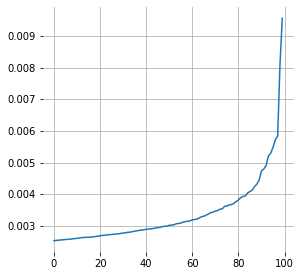

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_500.predict(X_test))

CPU times: user 508 ms, sys: 37.2 ms, total: 545 ms
Wall time: 438 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.75929140625

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

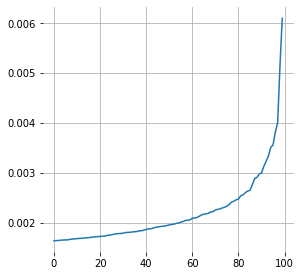

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_1000.predict(X_test))

CPU times: user 650 ms, sys: 54.4 ms, total: 704 ms
Wall time: 520 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.6909423828125

## Experiment 5 : 100000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 10D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 10D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 10D data set shape is:(100000, 10) and their densities shape is (100000,)
Train 10D data set shape is:(10000, 10) and their densities shape is (10000,)


### Fixing bandwidth - We choose `gamma` of the 10k size

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new]))  
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Best gamma:0.0009765625 with L1_error inf


Fixed gamma

In [ ]:
gamma = 16

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.17677669529663687

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.log(np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test]))

CPU times: user 1min 24s, sys: 2.01 s, total: 1min 26s
Wall time: 1min 26s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

2.5282425242861373

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = np.log(NaiveKDE_density.evaluate(X_test))

CPU times: user 2min 6s, sys: 3.51 s, total: 2min 10s
Wall time: 2min 10s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

2.528242524269189

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = np.log(TreeKDE_density.evaluate(X_test))

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

2.6216912628875138

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = KernelDensitybt_density.score_samples(X_test)

CPU times: user 3min 2s, sys: 976 ms, total: 3min 3s
Wall time: 3min 2s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

2.528242520760559

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = KernelDensitykdt_density.score_samples(X_test)

CPU times: user 3min 14s, sys: 1.06 s, total: 3min 15s
Wall time: 3min 14s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

2.528242523844839

#### `DMKDE`

Cross Validation for our method - We choose the `gamma` of the 10k size

In [ ]:
gammas = [2**i for i in range(-20,20,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = multi_gauss.log_prob(X_test_new).numpy()
    dim = 50
    fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
    qmd = models.QMDensity(fm_x, dim)
    qmd.compile()
    qmd.fit(X_train_new, epochs=1)
    qmd_densities = np.log(qmd_50.predict(X_test_new)*calculate_constant_qmkde(gamma = gamma, dimension = 10)) 
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(qmd_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

In [ ]:
gamma = 4

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 810us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 599 ms, sys: 49.4 ms, total: 649 ms
Wall time: 685 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

3.736951953125

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 820us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10) )

CPU times: user 1.56 s, sys: 283 ms, total: 1.84 s
Wall time: 1.45 s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.0880677734375

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

3125/3125 [==============================] - 55s 18ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 1min 58s, sys: 13.8 s, total: 2min 12s
Wall time: 1min 16s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

2.00518203125

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(10, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

3125/3125 [==============================] - 5s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = np.log(qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 10))

CPU times: user 14min 4s, sys: 14.1 s, total: 14min 18s
Wall time: 7min 29s


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

1.9811484375000001

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
gamma = 8

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

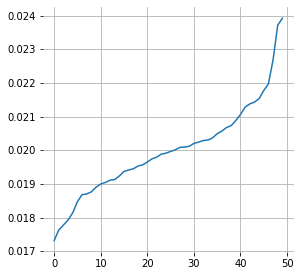

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_50.predict(X_test))

CPU times: user 423 ms, sys: 37.2 ms, total: 460 ms
Wall time: 352 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

3.73695234375

##### dim = 100

Train

In [ ]:
gamma = 5

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

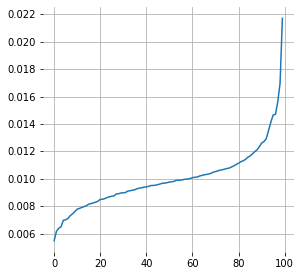

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_100.predict(X_test))

CPU times: user 441 ms, sys: 46.3 ms, total: 487 ms
Wall time: 413 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

2.0258318359375003

##### dim = 500

Train

In [ ]:
gamma = 6

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

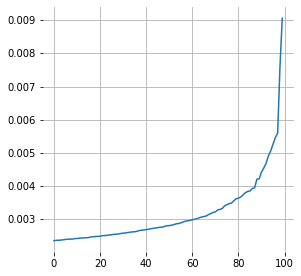

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_500.predict(X_test))

CPU times: user 400 ms, sys: 24.5 ms, total: 425 ms
Wall time: 349 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.7420312500000001

##### dim = 1000

Train

In [ ]:
gamma = 7

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(10, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

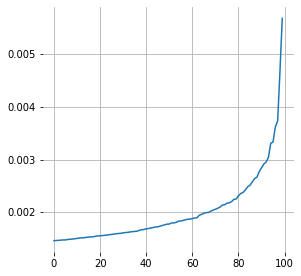

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  np.log(calculate_constant_qmkde(gamma = gamma,dimension = 10) * sgd_model_1000.predict(X_test))

CPU times: user 644 ms, sys: 61.7 ms, total: 706 ms
Wall time: 522 ms


$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

1.6718230468750002

## Final timing plot

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.75,15*0.75)

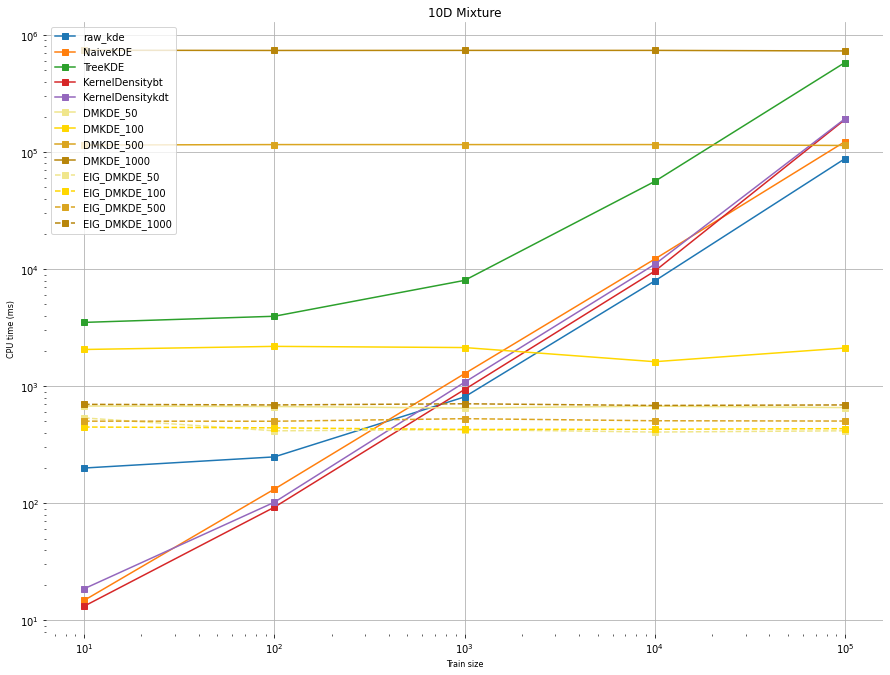

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [200,249,810,7940,88000]
#NaiveKDE
CPU_time_NaiveKDE = [14.8,132,1280,12200,123000]
#TreeKDE
CPU_time_TreeKDE = [3510,3960,8020,56200,583000]
#KernelDensitybt
CPU_time_KernelDensitybt = [13.2,92.5,937,9630,190000]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [18.6,102,1080,11000,193000]
#DMKDE_50
CPU_time_DMKDE_50 = [677,671,651,676,657]
#DMKDE_100
CPU_time_DMKDE_100 = [2060,2190,2140,1620,2120]
#DMKDE_500
CPU_time_DMKDE_500 = [115000,116000,116000,116000,114000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [742000,739000,740000,740000,732000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692]
plt.axes(frameon = 0)
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('10D Mixture')
plt.grid(b=True)
plt.savefig('time_10Dmixt.png', dpi=200)
plt.show()

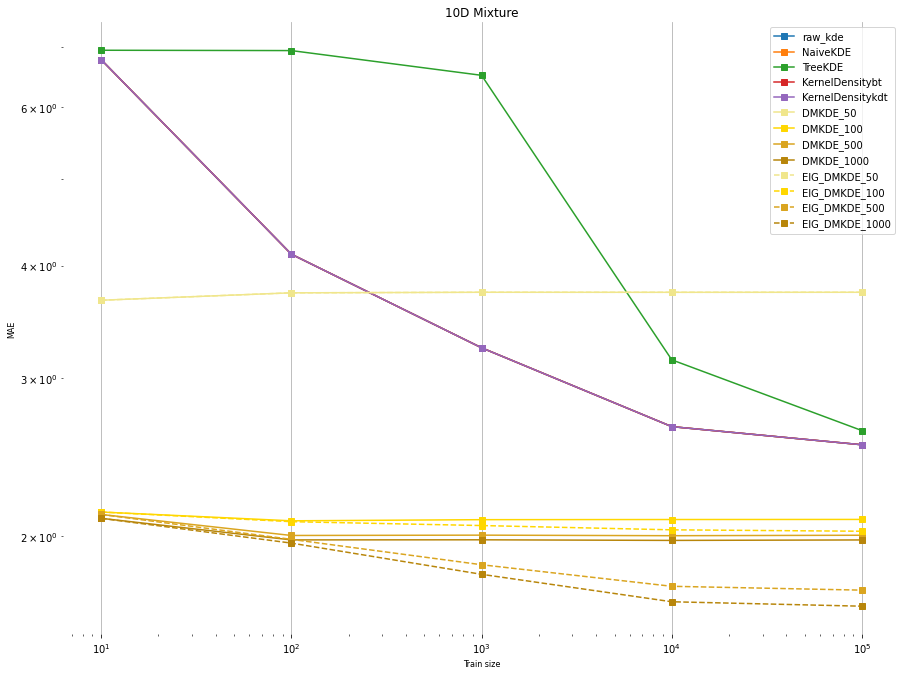

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [6.783428,4.120027,3.241781,2.648579,2.528242]
#NaiveKDE
error_NaiveKDE = [6.783428,4.120027,3.241719,2.648579,2.528242]
#TreeKDE
error_TreeKDE = [6.947680,6.941808,6.515438,3.14290,2.621691]
#KernelDensitybt
error_KernelDensitybt = [6.783428,4.120027,3.241276,2.648576,2.528242]
#KernelDensitykdt
error_KernelDensitykdt = [6.783428,4.120027,3.241335,2.648579,2.528242]
#DMKDE_50
error_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736951]
#DMKDE_100
error_DMKDE_100 = [2.128086,2.080765,2.086770,2.087589,2.088067]
#DMKDE_500
error_DMKDE_500 = [2.114925,2.003987,2.005682,2.002784,2.005182]
#DMKDE_1000
error_DMKDE_1000 = [2.094077,1.981399,1.981874,1.978818,1.981148]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823]

plt.axes(frameon = 0)
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('10D Mixture')
plt.grid(b=True)
plt.savefig('mae_10Dmixt.png', dpi=200)
plt.show()

100.000

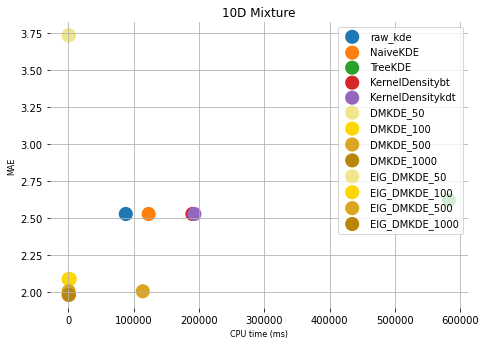

In [ ]:
#raw_kde
CPU_time_raw_kde = [200,249,810,7940,88000][4]
#NaiveKDE
CPU_time_NaiveKDE = [14.8,132,1280,12200,123000][4]
#TreeKDE
CPU_time_TreeKDE = [3510,3960,8020,56200,583000][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [13.2,92.5,937,9630,190000][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [18.6,102,1080,11000,193000][4]
#DMKDE_50
CPU_time_DMKDE_50 = [677,671,651,676,657][4]
#DMKDE_100
CPU_time_DMKDE_100 = [2060,2190,2140,1620,2120][4]
#DMKDE_500
CPU_time_DMKDE_500 = [115000,116000,116000,116000,114000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [742000,739000,740000,740000,732000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692][4]
#############################################################
#raw_kde
error_raw_kde = [6.783428,4.120027,3.241781,2.648579,2.528242][4]
#NaiveKDE
error_NaiveKDE = [6.783428,4.120027,3.241719,2.648579,2.528242][4]
#TreeKDE
error_TreeKDE = [6.947680,6.941808,6.515438,3.14290,2.621691][4]
#KernelDensitybt
error_KernelDensitybt = [6.783428,4.120027,3.241276,2.648576,2.528242][4]
#KernelDensitykdt
error_KernelDensitykdt = [6.783428,4.120027,3.241335,2.648579,2.528242][4]
#DMKDE_50
error_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736951][4]
#DMKDE_100
error_DMKDE_100 = [2.128086,2.080765,2.086770,2.087589,2.088067][4]
#DMKDE_500
error_DMKDE_500 = [2.114925,2.003987,2.005682,2.002784,2.005182][4]
#DMKDE_1000
error_DMKDE_1000 = [2.094077,1.981399,1.981874,1.978818,1.981148][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823][4]

plt.rcParams["figure.figsize"] = (10*0.75, 7*0.75)


scatter_100m = np.array([[CPU_time_raw_kde,error_raw_kde],
                [CPU_time_NaiveKDE,error_NaiveKDE],
                [CPU_time_TreeKDE,error_TreeKDE],
                [CPU_time_KernelDensitybt,error_KernelDensitybt],
                [CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                [CPU_time_DMKDE_50,error_DMKDE_50],
                [CPU_time_DMKDE_100,error_DMKDE_100],
                [CPU_time_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                [CPU_time_EIG_DMKDE_50,error_DMKDE_50],
                [CPU_time_EIG_DMKDE_100,error_DMKDE_100],
                [CPU_time_EIG_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000]
                ]).T
labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_50','DMKDE_100','DMKDE_500','DMKDE_1000','EIG_DMKDE_50','EIG_DMKDE_100'
,'EIG_DMKDE_500','EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','gold','goldenrod','darkgoldenrod','khaki','gold','goldenrod','darkgoldenrod'])

#
fig, ax = plt.subplots()
j=0
for color,label in zip(colors,labels):
    x, y = (scatter_100m[0][j],scatter_100m[1][j])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
    j+=1
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('10D Mixture')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_10Dmixt.png', dpi=200)

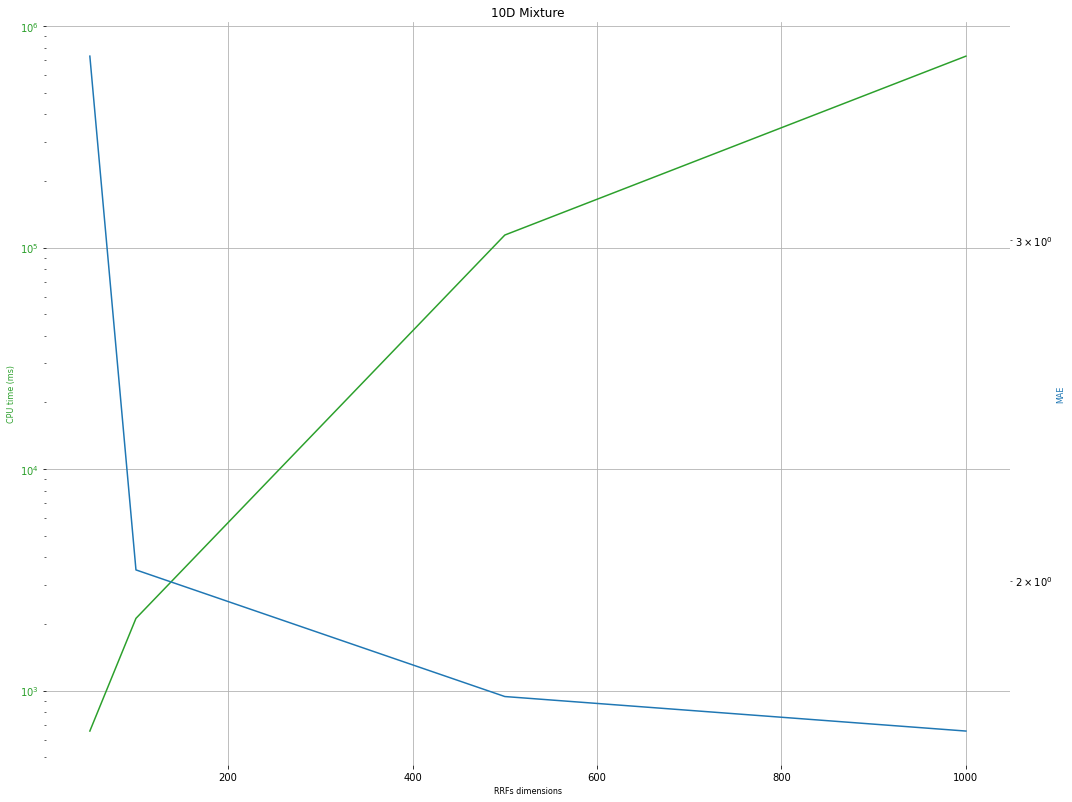

In [ ]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692][4]
####################################################
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823][4]
t = [50.,100.,500.,1000.]

data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('10D Mixture')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_10Dmixt.png', dpi=200)
plt.show()

## Final timing plot

In [9]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=2f59b31bf63f221ac5d341ca2cf49e5b6b6c3357ebe209fc7e379978cd84230c
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [10]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install latex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [11]:
plt.style.reload_library()
plt.style.use(['science','ieee','no-latex'])

In [12]:
size = (5,4)

In [13]:
plt.rcParams["figure.figsize"] = size

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


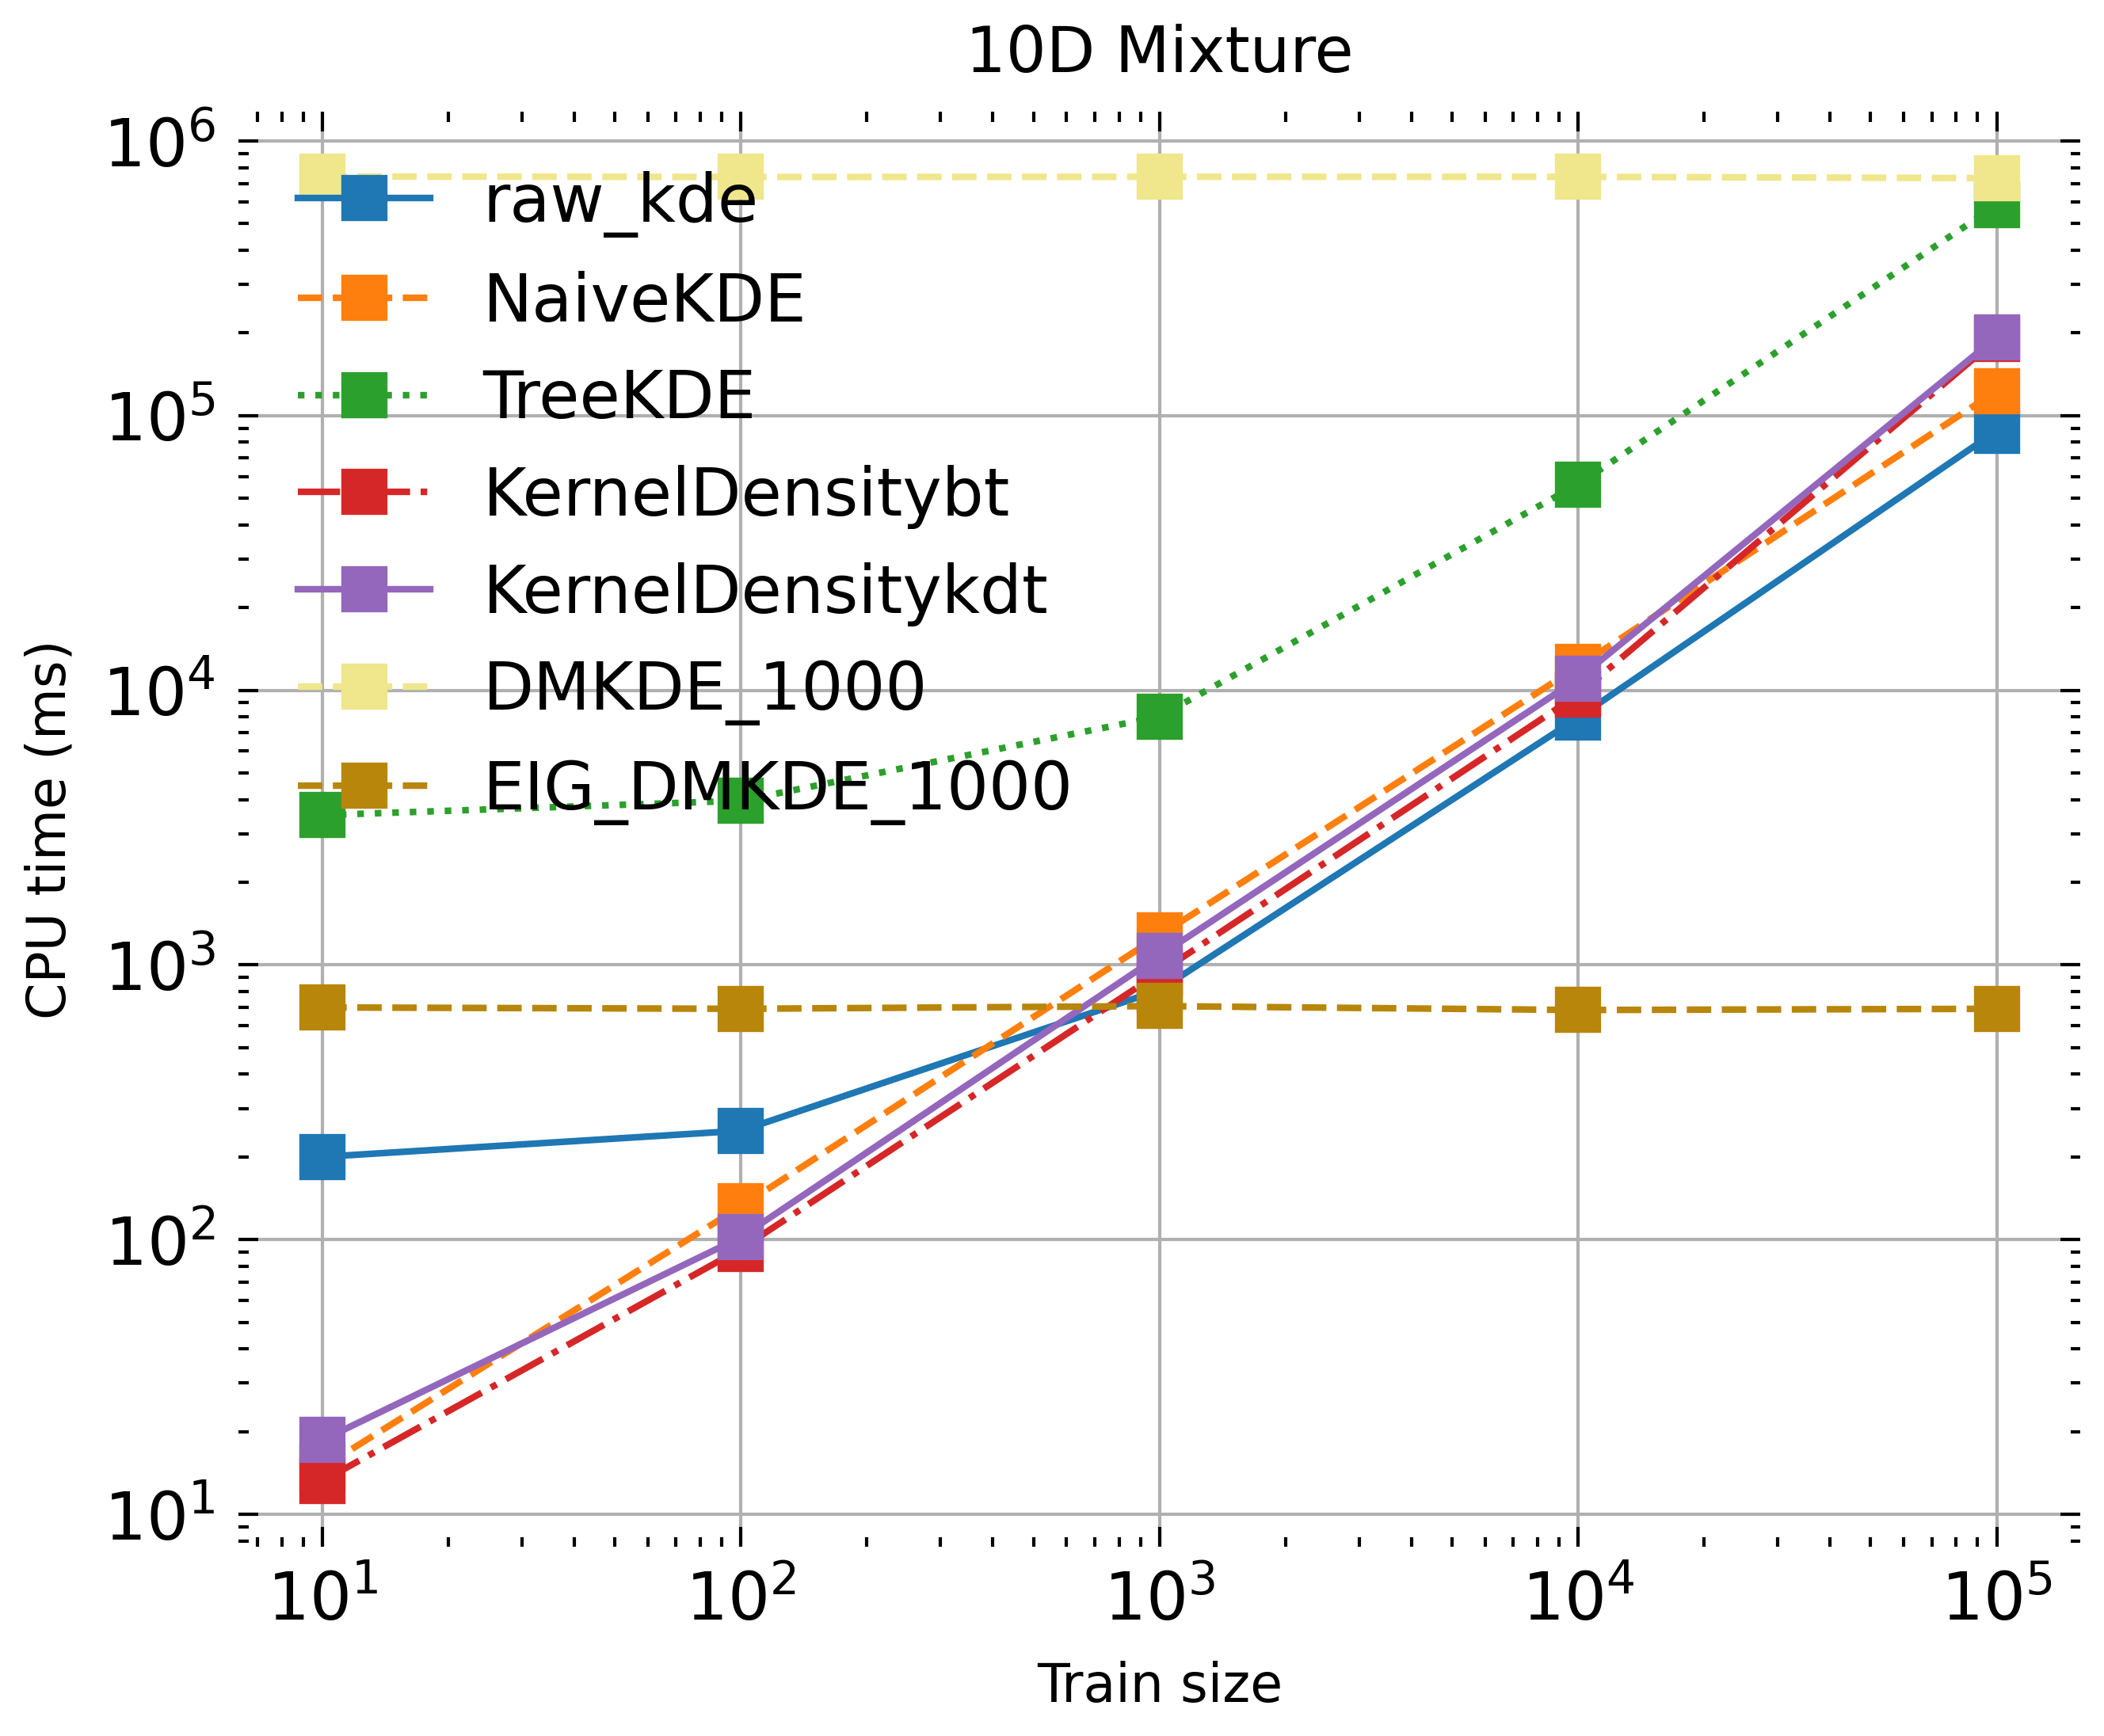

In [14]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [200,249,810,7940,88000]
#NaiveKDE
CPU_time_NaiveKDE = [14.8,132,1280,12200,123000]
#TreeKDE
CPU_time_TreeKDE = [3510,3960,8020,56200,583000]
#KernelDensitybt
CPU_time_KernelDensitybt = [13.2,92.5,937,9630,190000]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [18.6,102,1080,11000,193000]
#DMKDE_50
CPU_time_DMKDE_50 = [677,671,651,676,657]
#DMKDE_100
CPU_time_DMKDE_100 = [2060,2190,2140,1620,2120]
#DMKDE_500
CPU_time_DMKDE_500 = [115000,116000,116000,116000,114000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [742000,739000,740000,740000,732000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692]
plt.axes(frameon = 0)
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('10D Mixture')
plt.grid(b=True)
plt.savefig('time_10Dmixt.png', dpi=200)
plt.show()

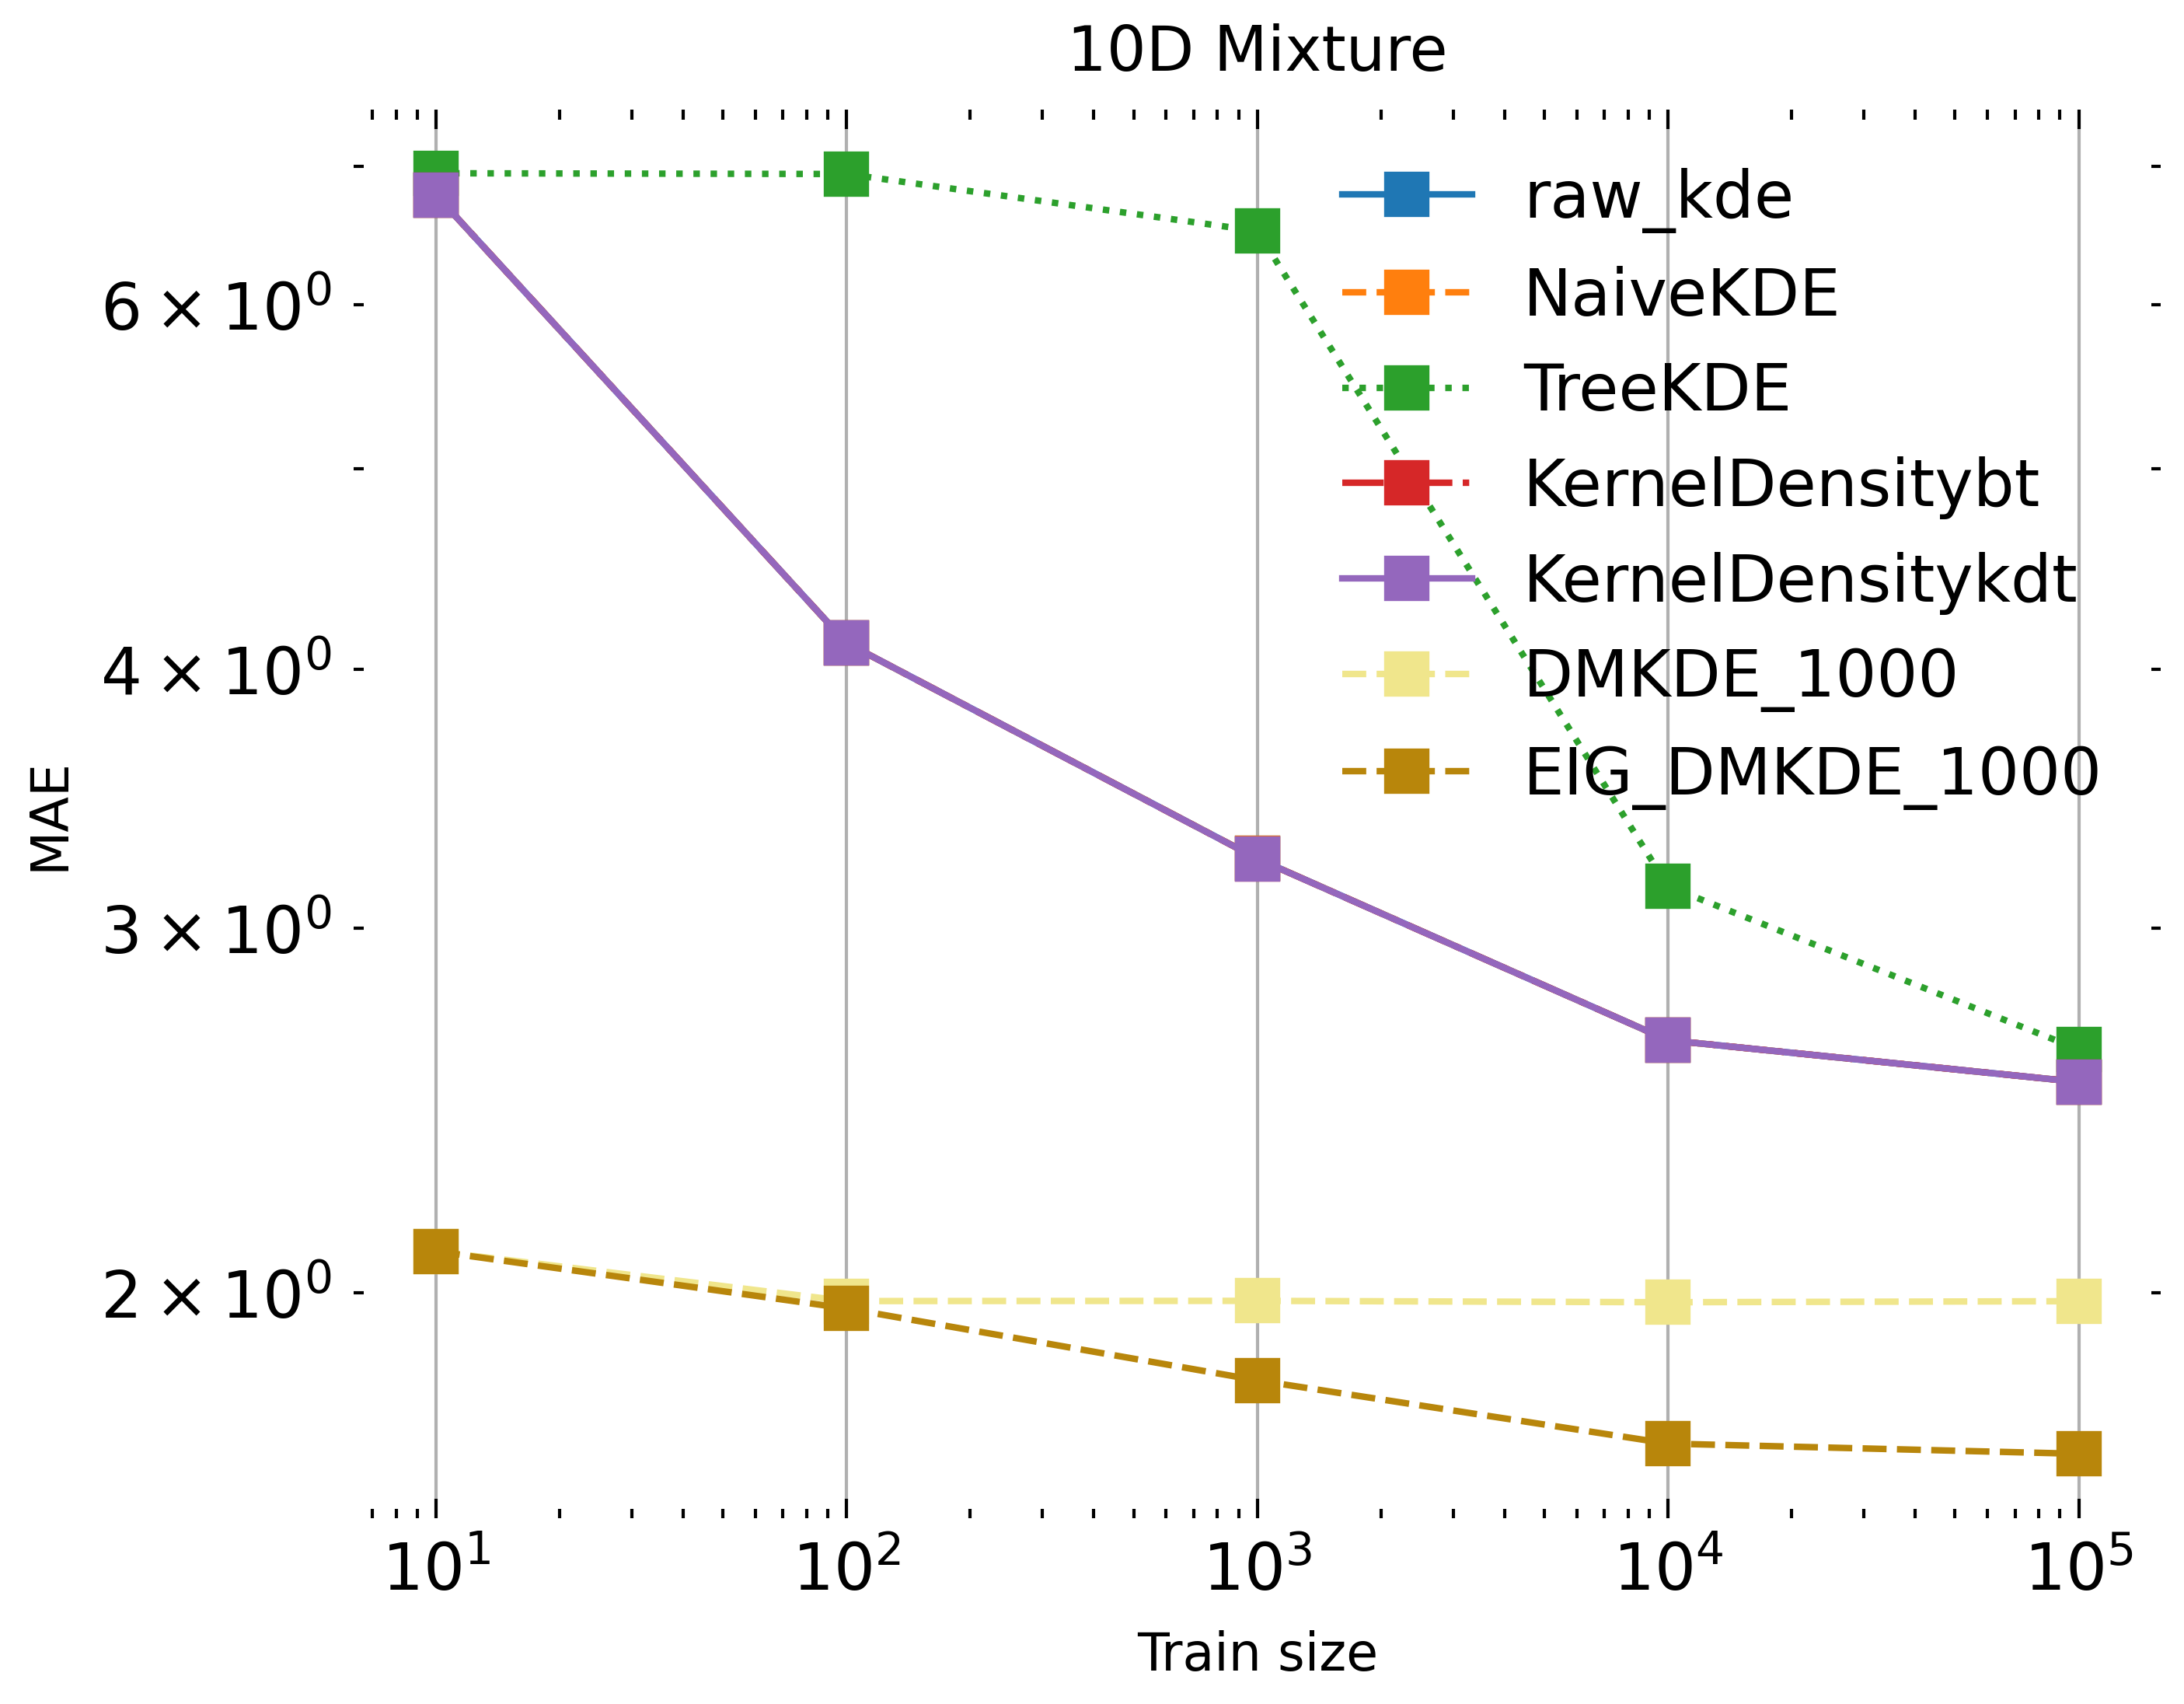

In [15]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [6.783428,4.120027,3.241781,2.648579,2.528242]
#NaiveKDE
error_NaiveKDE = [6.783428,4.120027,3.241719,2.648579,2.528242]
#TreeKDE
error_TreeKDE = [6.947680,6.941808,6.515438,3.14290,2.621691]
#KernelDensitybt
error_KernelDensitybt = [6.783428,4.120027,3.241276,2.648576,2.528242]
#KernelDensitykdt
error_KernelDensitykdt = [6.783428,4.120027,3.241335,2.648579,2.528242]
#DMKDE_50
error_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736951]
#DMKDE_100
error_DMKDE_100 = [2.128086,2.080765,2.086770,2.087589,2.088067]
#DMKDE_500
error_DMKDE_500 = [2.114925,2.003987,2.005682,2.002784,2.005182]
#DMKDE_1000
error_DMKDE_1000 = [2.094077,1.981399,1.981874,1.978818,1.981148]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823]

plt.axes(frameon = 0)
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('10D Mixture')
plt.grid(b=True)
plt.savefig('mae_10Dmixt.png', dpi=200)
plt.show()

100.000

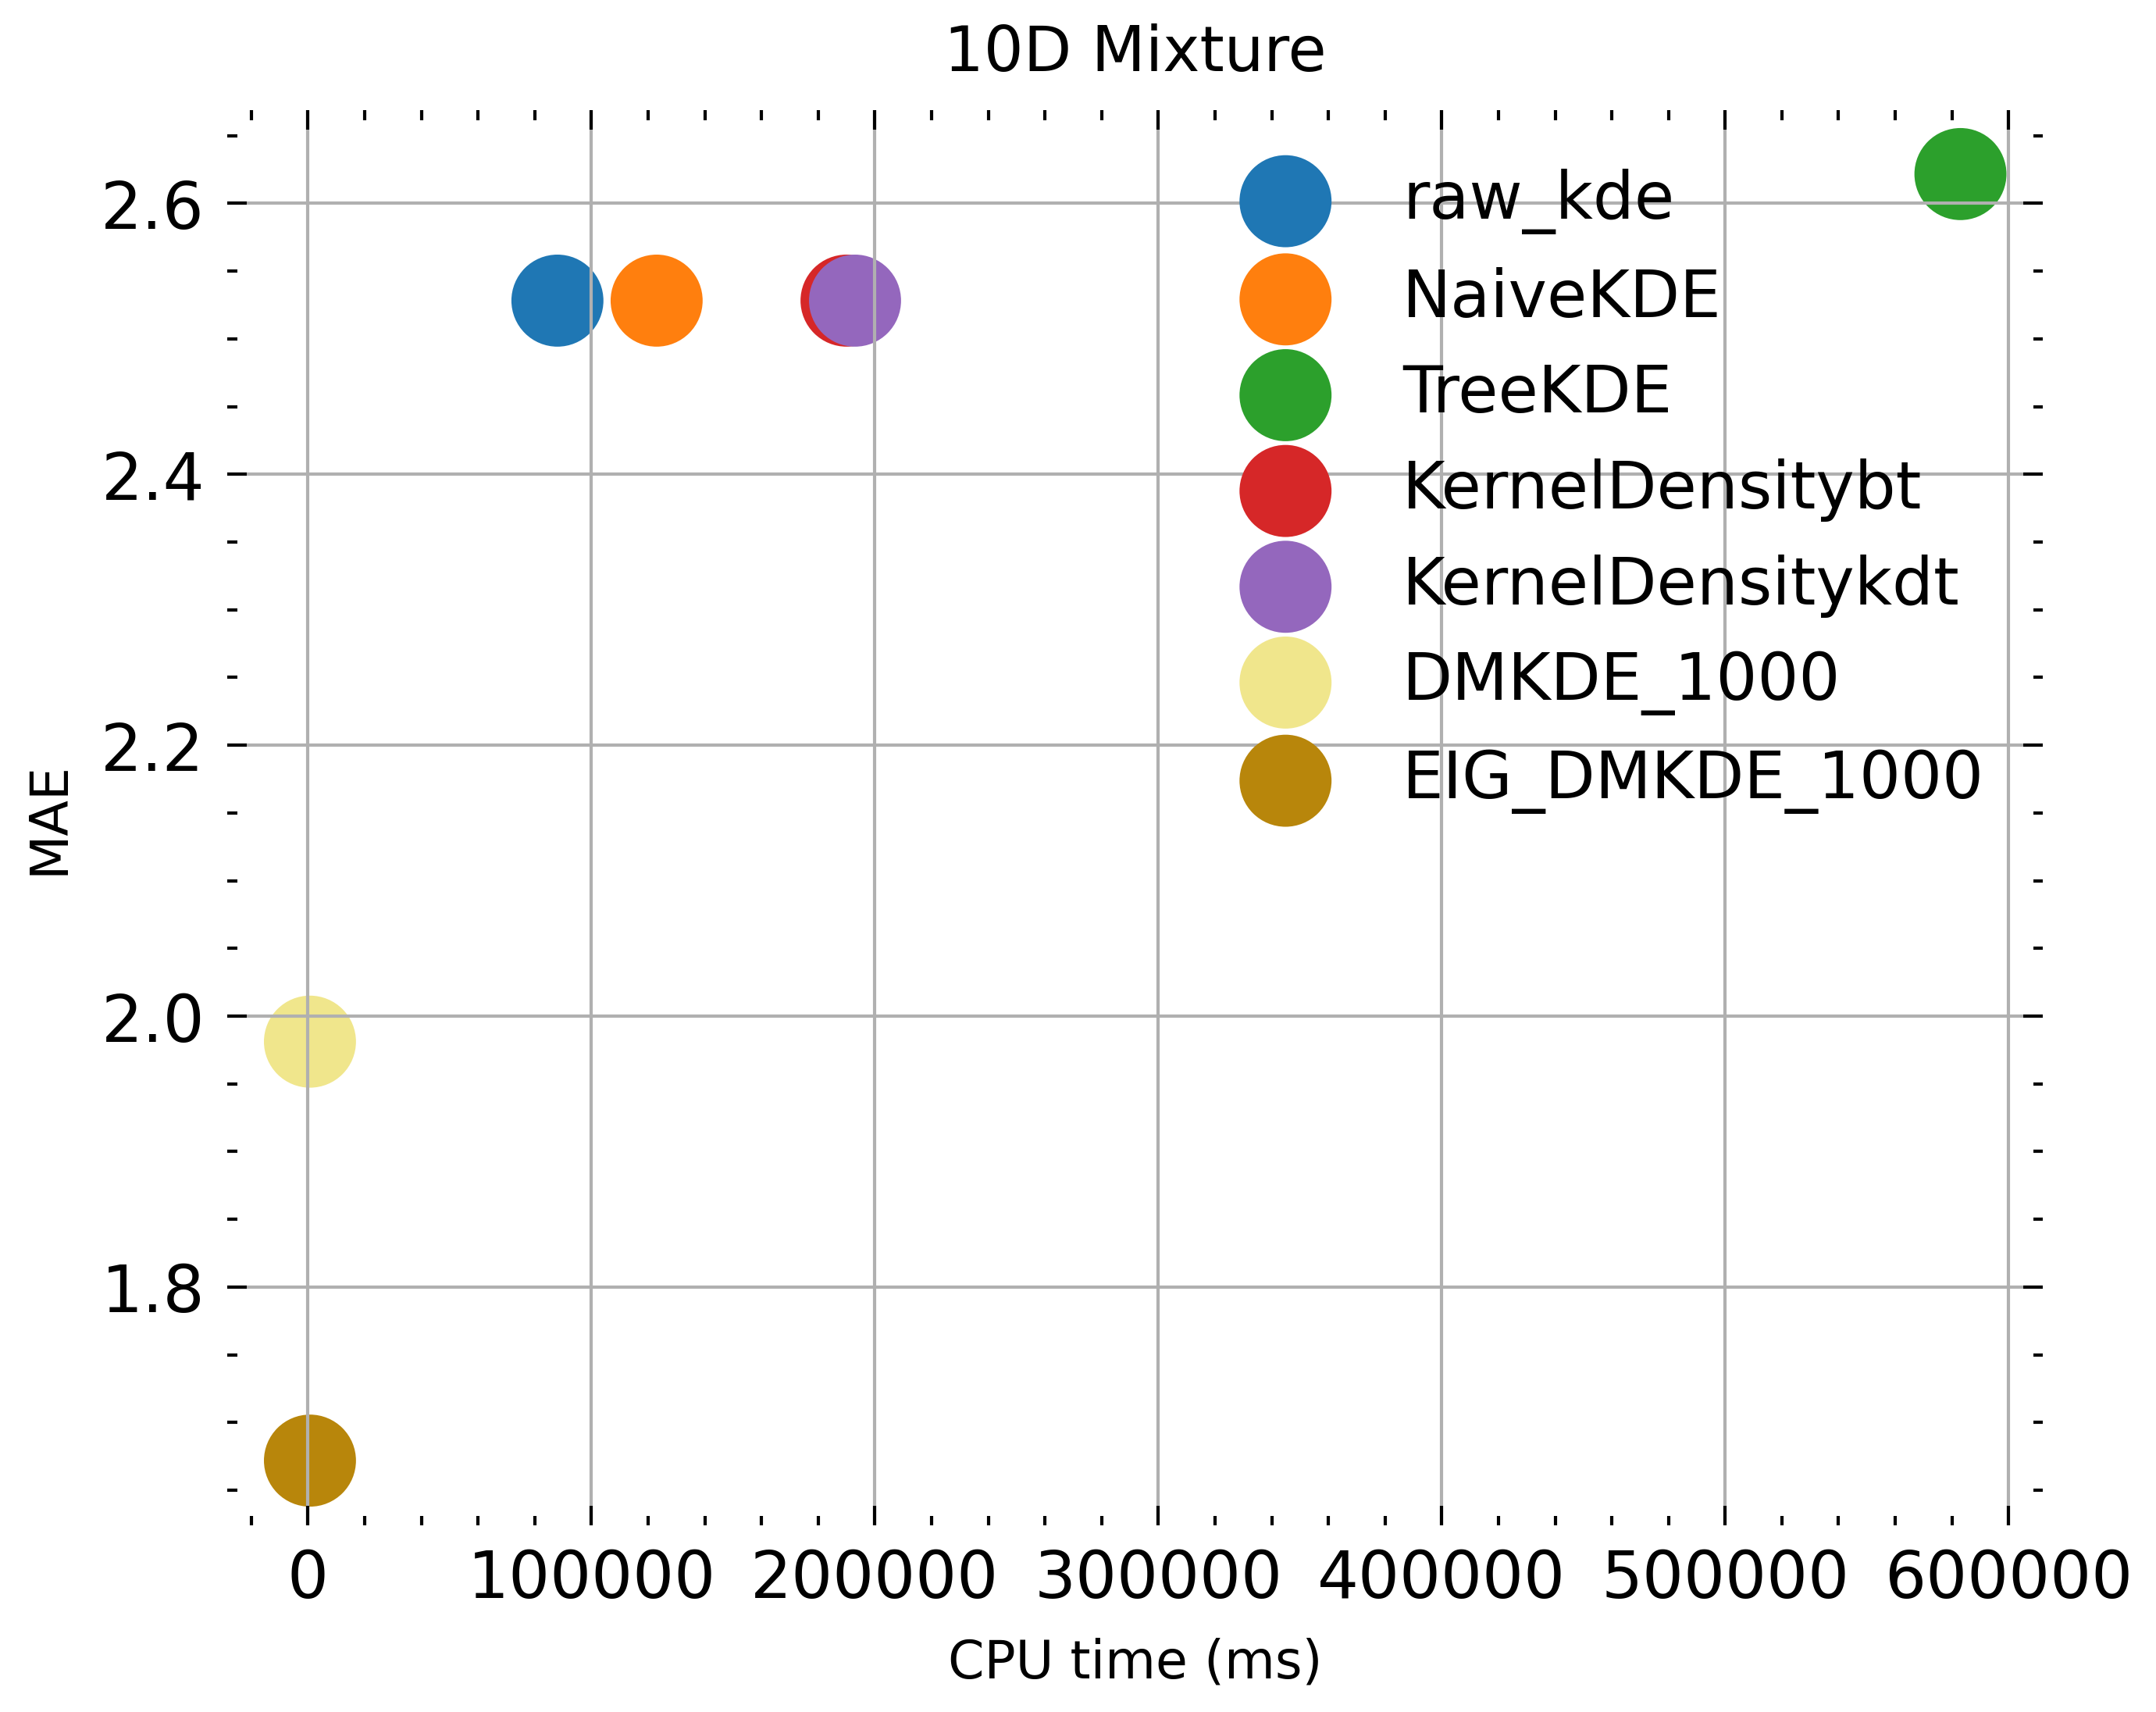

In [17]:
#raw_kde
CPU_time_raw_kde = [200,249,810,7940,88000][4]
#NaiveKDE
CPU_time_NaiveKDE = [14.8,132,1280,12200,123000][4]
#TreeKDE
CPU_time_TreeKDE = [3510,3960,8020,56200,583000][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [13.2,92.5,937,9630,190000][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [18.6,102,1080,11000,193000][4]
#DMKDE_50
CPU_time_DMKDE_50 = [677,671,651,676,657][4]
#DMKDE_100
CPU_time_DMKDE_100 = [2060,2190,2140,1620,2120][4]
#DMKDE_500
CPU_time_DMKDE_500 = [115000,116000,116000,116000,114000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [742000,739000,740000,740000,732000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692][4]
#############################################################
#raw_kde
error_raw_kde = [6.783428,4.120027,3.241781,2.648579,2.528242][4]
#NaiveKDE
error_NaiveKDE = [6.783428,4.120027,3.241719,2.648579,2.528242][4]
#TreeKDE
error_TreeKDE = [6.947680,6.941808,6.515438,3.14290,2.621691][4]
#KernelDensitybt
error_KernelDensitybt = [6.783428,4.120027,3.241276,2.648576,2.528242][4]
#KernelDensitykdt
error_KernelDensitykdt = [6.783428,4.120027,3.241335,2.648579,2.528242][4]
#DMKDE_50
error_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736951][4]
#DMKDE_100
error_DMKDE_100 = [2.128086,2.080765,2.086770,2.087589,2.088067][4]
#DMKDE_500
error_DMKDE_500 = [2.114925,2.003987,2.005682,2.002784,2.005182][4]
#DMKDE_1000
error_DMKDE_1000 = [2.094077,1.981399,1.981874,1.978818,1.981148][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823][4]



scatter_100m ={"raw_kde": [CPU_time_raw_kde,error_raw_kde],
                'NaiveKDE':[CPU_time_NaiveKDE,error_NaiveKDE],
                'TreeKDE':[CPU_time_TreeKDE,error_TreeKDE],
                'KernelDensitybt':[CPU_time_KernelDensitybt,error_KernelDensitybt],
                'KernelDensitykdt':[CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                'DMKDE_50':[CPU_time_DMKDE_50,error_DMKDE_50],
                'DMKDE_100':[CPU_time_DMKDE_100,error_DMKDE_100],
                'DMKDE_500':[CPU_time_DMKDE_500,error_DMKDE_500],
                'DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                'EIG_DMKDE_50':[CPU_time_EIG_DMKDE_50,error_EIG_DMKDE_50],
                'EIG_DMKDE_100':[CPU_time_EIG_DMKDE_100,error_EIG_DMKDE_100],
                'EIG_DMKDE_500':[CPU_time_EIG_DMKDE_500,error_EIG_DMKDE_500],
                'EIG_DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_EIG_DMKDE_1000]
          }

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_1000', 'EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','darkgoldenrod'])#
fig, ax = plt.subplots()
for color,label in zip(colors,labels):
    x, y = (scatter_100m[label][0],scatter_100m[label][1])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('10D Mixture')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_10Dmixt.png', dpi=200)

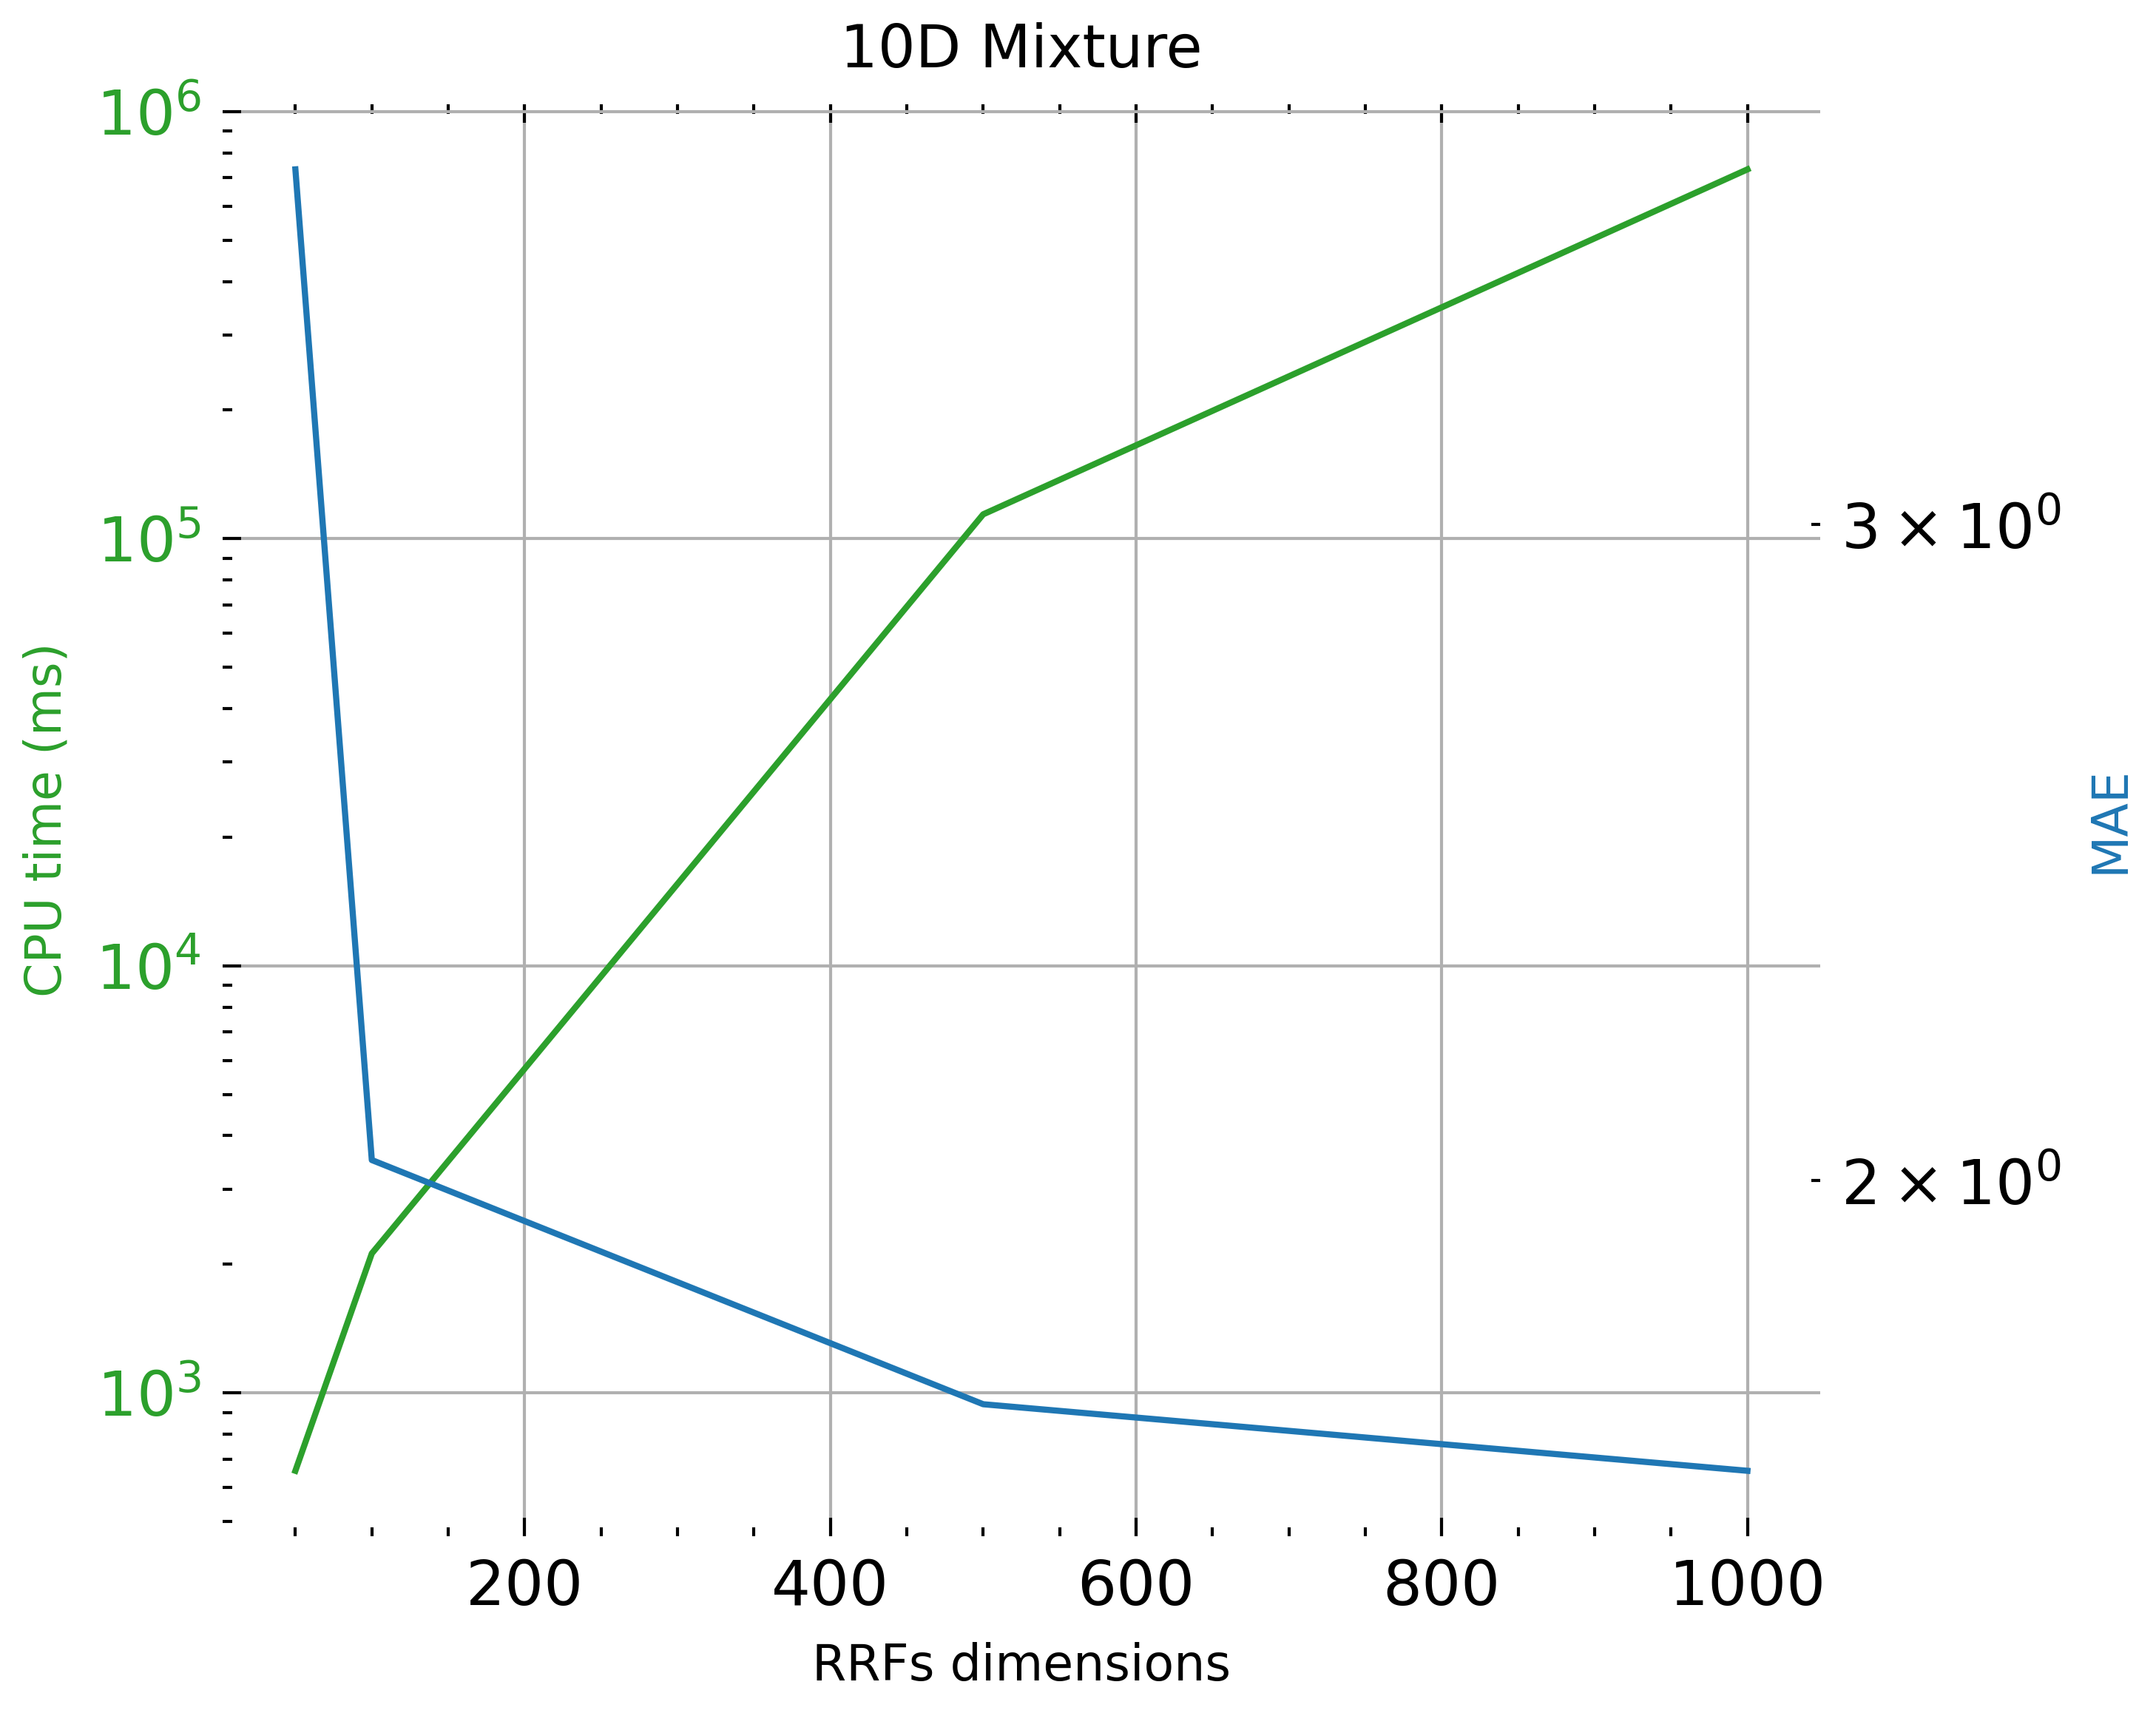

In [18]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [536,416,426,406,416][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [448,441,427,429,434][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [503,502,528,507,504][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [700,692,708,685,692][4]
####################################################
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [3.661528,3.731667,3.737024,3.736647,3.736952][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [2.128086,2.076112,2.055598,2.033189,2.025831][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [2.114925,1.984155,1.859224,1.759291,1.742031][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [2.094077,1.965220,1.814158,1.690942,1.671823][4]
t = [50.,100.,500.,1000.]

data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('10D Mixture')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_10Dmixt.png', dpi=200)
plt.show()